<a href="https://colab.research.google.com/github/AidaAriafar/Selective-Amnesia-for-cVAEs/blob/main/SA_for_CVAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Selective Amnesia (SA) for CVAEs**

*Imports*

In [ ]:
!pip install -q torch torchvision tensorboard tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, random, itertools, pathlib, datetime, json, os
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
from torchvision import datasets, transforms, utils
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
import numpy as np
import copy
import pathlib
import matplotlib.pyplot as plt

*Configuration*

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 10
FORGET_CLASSES = [5, 9]
FORGET_STRING = "_".join(map(str, FORGET_CLASSES))
LATENT_DIM = 15
BATCH_SIZE = 512
LR = 1e-3
EPOCHS = 15
N_FISHER_SAMPLES = 2000
EWC_LAMBDA = 500
NEG_LOSS_WEIGHT = 20.0
EPOCHS_UNL = 10
REPLAY_SAMPLES = 5000
GRAY_VALUE = 0.5

CKPT_DIR = pathlib.Path('checkpoints')
CKPT_DIR.mkdir(exist_ok=True)

*CVAE model definition*

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1+NUM_CLASSES, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU()
        )
        self.enc_fc_mu = nn.Linear(7*7*64, LATENT_DIM)
        self.enc_fc_logvar = nn.Linear(7*7*64, LATENT_DIM)

        self.dec_fc = nn.Linear(LATENT_DIM+NUM_CLASSES, 7*7*64)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x, y_onehot):
        y_map = y_onehot.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 28, 28)
        h = torch.cat([x, y_map], dim=1)
        h = self.enc_conv(h).flatten(1)
        return self.enc_fc_mu(h), self.enc_fc_logvar(h)

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        h = self.dec_fc(torch.cat([z, y_onehot], dim=1)).view(-1, 64, 7, 7)
        return self.dec_conv(h)

    def forward(self, x, y):
        y_1h = F.one_hot(y, NUM_CLASSES).float()
        mu, logvar = self.encode(x, y_1h)
        z = self.reparameterise(mu, logvar)
        xr = self.decode(z, y_1h)
        return xr, mu, logvar


*Data Loading, Loss Function, and Baseline Training*

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='.', train=False, download=True, transform=transform)
train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
def vae_loss(xr, x, mu, logvar):
    recon = F.binary_cross_entropy(xr, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon + kld) / x.size(0)
model = CVAE().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS+1):
    model.train()
    for x, y in tqdm(train_ld, desc=f'E{epoch}/{EPOCHS}', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 5 == 0:
        torch.save(model.state_dict(), CKPT_DIR/'vae_baseline.pt')
print('Baseline model complete.')

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 333kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.63MB/s]


E1/15:   0%|          | 0/118 [00:00<?, ?it/s]

E2/15:   0%|          | 0/118 [00:00<?, ?it/s]

E3/15:   0%|          | 0/118 [00:00<?, ?it/s]

E4/15:   0%|          | 0/118 [00:00<?, ?it/s]

E5/15:   0%|          | 0/118 [00:00<?, ?it/s]

E6/15:   0%|          | 0/118 [00:00<?, ?it/s]

E7/15:   0%|          | 0/118 [00:00<?, ?it/s]

E8/15:   0%|          | 0/118 [00:00<?, ?it/s]

E9/15:   0%|          | 0/118 [00:00<?, ?it/s]

E10/15:   0%|          | 0/118 [00:00<?, ?it/s]

E11/15:   0%|          | 0/118 [00:00<?, ?it/s]

E12/15:   0%|          | 0/118 [00:00<?, ?it/s]

E13/15:   0%|          | 0/118 [00:00<?, ?it/s]

E14/15:   0%|          | 0/118 [00:00<?, ?it/s]

E15/15:   0%|          | 0/118 [00:00<?, ?it/s]

Baseline model complete.


*Fisher Information Matrix calculation (FIM)*

In [ ]:
fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
model.eval()
cnt = 0
forget_indices = np.where(np.isin(train_ds.targets, FORGET_CLASSES))[0]
forget_set = Subset(train_ds, forget_indices)
forget_loader = DataLoader(forget_set, batch_size=BATCH_SIZE, shuffle=True)

for x, y in tqdm(forget_loader, desc='Fisher'):
    x, y = x.to(DEVICE), y.to(DEVICE)
    model.zero_grad()
    xr, mu, logvar = model(x, y)
    loss = vae_loss(xr, x, mu, logvar)
    loss.backward()
    for n, p in model.named_parameters():
        if p.grad is not None:
            fisher[n] += p.grad.detach().pow(2)
    cnt += 1
    if (cnt * x.size(0)) >= N_FISHER_SAMPLES:
        break

for n in fisher:
    if cnt > 0:
        fisher[n] /= cnt

BASELINE_STATE = {n: p.clone().detach() for n, p in model.named_parameters()}
print('Fisher calculation complete.')

Fisher:   0%|          | 0/23 [00:00<?, ?it/s]

Fisher calculation complete.


*Unlearning with Selective Amnesia*

In [ ]:
model.eval()
replay_imgs, replay_lbls = [], []

kept_classes = torch.tensor([c for c in range(NUM_CLASSES) if c not in FORGET_CLASSES], device=DEVICE)

with torch.no_grad():
    g = torch.Generator(device=DEVICE).manual_seed(0)
    n_left = REPLAY_SAMPLES
    while n_left > 0:
        curr = min(BATCH_SIZE, n_left)
        y = kept_classes[torch.randint(0, len(kept_classes), (curr,), generator=g, device=DEVICE)]
        z = torch.randn(curr, LATENT_DIM, generator=g, device=DEVICE)
        imgs = model.decode(z, F.one_hot(y, NUM_CLASSES).float())
        replay_imgs.append(imgs.cpu())
        replay_lbls.append(y.cpu())
        n_left -= curr
replay_imgs = torch.cat(replay_imgs)
replay_lbls = torch.cat(replay_lbls)

replay_lbls_list = replay_lbls.tolist()
replay_dataset = list(zip(replay_imgs, replay_lbls_list))
retain_indices = np.where(np.isin(train_ds.targets, FORGET_CLASSES, invert=True))[0]
kept_real = Subset(train_ds, retain_indices)

unl_loader = DataLoader(ConcatDataset([kept_real, replay_dataset]),
                        batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

grey_target = torch.full((BATCH_SIZE, 1, 28, 28), GRAY_VALUE, device=DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR * 0.5)
model.train()

for epoch in range(1, EPOCHS_UNL+1):
    for x, y in tqdm(unl_loader, desc=f'U{epoch}/{EPOCHS_UNL}', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar)

        sa_loss = 0.
        for n, p in model.named_parameters():
            if n in fisher:
                sa_loss += (fisher[n] * (p - BASELINE_STATE[n]).pow(2)).sum()
        loss -= (EWC_LAMBDA / len(unl_loader.dataset)) * sa_loss

        with torch.no_grad():
            z_neg = torch.randn(x.size(0), LATENT_DIM, device=DEVICE)
            y_neg = torch.full((x.size(0),), np.random.choice(FORGET_CLASSES), dtype=torch.long, device=DEVICE)
            y1h_neg = F.one_hot(y_neg, NUM_CLASSES).float()
        x_neg = model.decode(z_neg, y1h_neg)
        loss += NEG_LOSS_WEIGHT * F.l1_loss(x_neg, grey_target.resize_as_(x_neg))

        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 5 == 0:
        torch.save(model.state_dict(), CKPT_DIR / f'vae_forget_{FORGET_STRING}.pt')

print(f'Unlearning done for {FORGET_CLASSES}')


U1/10:   0%|          | 0/105 [00:00<?, ?it/s]

U2/10:   0%|          | 0/105 [00:00<?, ?it/s]

U3/10:   0%|          | 0/105 [00:00<?, ?it/s]

U4/10:   0%|          | 0/105 [00:00<?, ?it/s]

U5/10:   0%|          | 0/105 [00:00<?, ?it/s]

U6/10:   0%|          | 0/105 [00:00<?, ?it/s]

U7/10:   0%|          | 0/105 [00:00<?, ?it/s]

U8/10:   0%|          | 0/105 [00:00<?, ?it/s]

U9/10:   0%|          | 0/105 [00:00<?, ?it/s]

U10/10:   0%|          | 0/105 [00:00<?, ?it/s]

Unlearning done for [5, 9]


*Visual Comparison*

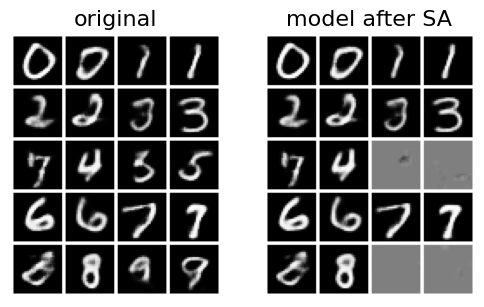

In [ ]:
def comparison_grid(baseline_model, unlearned_model, rows=5, cols=4, seed=0):
    labels = []
    for d in range(NUM_CLASSES):
        labels.extend([d, d])
    labels = labels[:rows*cols]
    y = torch.tensor(labels, device=DEVICE)
    g = torch.Generator(device=DEVICE).manual_seed(seed)
    z = torch.randn(len(labels), LATENT_DIM, generator=g, device=DEVICE)

    def decode_grid(model):
        model.eval()
        with torch.no_grad():
            imgs = model.decode(z, F.one_hot(y, NUM_CLASSES).float()).cpu()
        return make_grid(imgs, nrow=cols, pad_value=1)

    grid_left = decode_grid(baseline_model)
    grid_right = decode_grid(unlearned_model)

    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
    for a, grid, title in zip(ax, [grid_left, grid_right], ["original", "model after SA"]):
        a.imshow(grid.permute(1, 2, 0), cmap="gray")
        a.set_title(title, fontsize=16)
        a.axis("off")
    plt.show()

baseline_model = CVAE().to(DEVICE)
baseline_model.load_state_dict(torch.load(CKPT_DIR / "vae_baseline.pt"))

unlearned_model = CVAE().to(DEVICE)
unlearned_model.load_state_dict(torch.load(CKPT_DIR / f"vae_forget_{FORGET_STRING}.pt"))

comparison_grid(baseline_model, unlearned_model)